In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import torch as d2l
import random
import os
import torch.nn.functional as F
from torch.autograd import grad
import torch.nn.init as init
d2l.use_svg_display()

import math

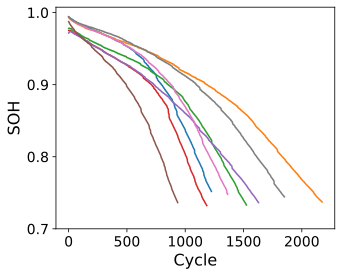

In [13]:
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 6) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
def make_sequences(text, window_size):
    """用容量作为文本序列text,window是窗口的大小"""
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
    return np.array(x), np.array(y)
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
Battery_list = ['1-1', '1-2', '1-3', '1-4','1-5','1-6','1-7','1-8']
data_root='../data/HUST_data/all_path/'
plt.figure(figsize=(5, 4))
for name in Battery_list:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    # print(features.shape)
    # print(SOHs.shape)
    plt.plot(SOHs)
    plt.yticks([0.7,0.8,0.9,1.0],fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    # print(features[1][0])
# plt.show()

## 参数配置

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path = '../data/HUST_data/all_path/' + b_n + '.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_features=np.concatenate((train_data[0][0],train_data[5][0],train_data[2][0],train_data[3][0],train_data[7][0]),axis=0)
    train_labls=np.concatenate((train_data[0][1],train_data[5][1],train_data[2][1],train_data[3][1],train_data[7][1]),axis=0)
    train_valid_features=torch.from_numpy(train_features).float()
    train_valid_labels=torch.from_numpy(train_labls).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(0.2 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_5_data,test_6_data,test_7_data=[np.concatenate((train_data[0][0],train_data[5][0],train_data[2][0],train_data[3][0],train_data[7][0]),axis=0),np.concatenate((train_data[0][1],train_data[5][1],train_data[2][1],train_data[3][1],train_data[7][1]),axis=0)],[train_data[6][0],train_data[6][1]],[train_data[4][0],train_data[4][1]]
    return train_loader, val_loader, test_5_data,test_6_data,test_7_data

a,b,_,_,_=get_data()
for x,y in b:
    print(x.shape)

torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([3

## 网络结构

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/10)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
        

In [5]:
def train(lr=0.003,epochs=100, weight_decay=0, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if val_mse<7e-5 or (epoch+1)==epochs:
            model=model.cpu()
            torch.save(model.state_dict(), '../pretrained/hust_model.pth')
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists

In [7]:
# tests=[]
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# for i in range(5):
#     test_result,_=train(seed=i,device=device)
#     tests.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0005, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [18]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae

In [19]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests)):
#     for j in range(len(tests[0])):
#         real,pred=tests[i][j][0],tests[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_results,lists=train(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0010, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0005, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0032, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [7]:
reals=[]
preds=[]
for i in range(3):
    real,pred=test_results[i][0],test_results[i][1]
    reals.append(real)
    preds.append(pred)
reals=np.concatenate(reals,axis=0)
preds=np.concatenate(preds,axis=0).squeeze()
path='D:/Pywork/CNN_ATTENTION_PINN/new/results/preds/hust.npz'
np.savez(path,reals=reals,preds=preds)

In [8]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae
def mape(sequence_true, sequence_pred):
    """
    计算两个序列的MAPE（Mean Absolute Percentage Error）

    参数:
    sequence_true: 实际值序列
    sequence_pred: 预测值序列

    返回:
    mape: 平均绝对百分比误差
    """
    if len(sequence_true) != len(sequence_pred):
        raise ValueError("两个序列的长度必须相同")

    # 计算绝对百分比误差
    ape = [abs((true - pred) / true) for true, pred in zip(sequence_true, sequence_pred) if true != 0]

    # 计算平均绝对百分比误差
    mape = sum(ape) / len(ape)

    return mape

# 示例使用
sequence_true = [100, 200, 300, 400, 500]
sequence_pred = [90, 210, 310, 380, 480]
print("MAPE:", mape(sequence_true, sequence_pred))
def r_squared(y_true, y_pred):
    """
    计算两个序列的R方（R-squared）

    参数:
    y_true: 实际值序列
    y_pred: 预测值序列

    返回:
    r2: R方值
    """
    # 计算实际值的平均值
    y_mean = sum(y_true) / len(y_true)
    
    # 计算总平方和（Total Sum of Squares, TSS）
    ss_total = sum((y_true - y_mean) ** 2)
    
    # 计算回归平方和（Regression Sum of Squares, RSS）
    ss_residual = sum((y_true - y_pred) ** 2)
    
    # 计算R方
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

MAPE: 0.05466666666666666


In [9]:
rmse_all = []
mae_all = []
mape_all = []
r2 = []
num = 0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real, pred = tests[i][j][0], tests[i][j][1].reshape(-1)
        rmse = evaluation(real, pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real, pred))
        mape_all.append(mape(real, pred))
        r2.append(r_squared(real, pred))
        num += 1
print("RMSE:", rmse_all)
print("MAE:", mae_all)
print("MAPE:", mape_all)
print("R2:", r2)

RMSE: [0.01319168320201145, 0.018947346972750842, 0.01918077180364281, 0.013795303967506277, 0.01546165600633895, 0.017699304441619733, 0.014456872594151023, 0.023279575499786695, 0.0168253112329674, 0.00921934763932654, 0.009873218782948709, 0.019130642031173255, 0.008967664685566007, 0.014628635552252765, 0.011521342552319977]
MAE: [0.010919497756457182, 0.013505555113334965, 0.015050563421840968, 0.010638500479703876, 0.009372530118409906, 0.015972348730551682, 0.010841268471324791, 0.01974458588538429, 0.013043836707995509, 0.006550371468736005, 0.007442259881492081, 0.017408833204989975, 0.006303740761294951, 0.012386149588250689, 0.008401321886482852]
MAPE: [0.012192801825190185, 0.01587891348311458, 0.017929362898175667, 0.012058471645833634, 0.011160367096054946, 0.018340864342818782, 0.012497211861927746, 0.021608975471118685, 0.015309954081585397, 0.007536433704154649, 0.008498676457554116, 0.02008894880472866, 0.007240475377237474, 0.013681505842380893, 0.009854895573913822]

[0.99432772 0.99432649 0.99430237 ... 0.73681295 0.73630225 0.73629702]
[0.9728833  0.9724234  0.97452766 ... 0.7905266  0.78252745 0.7738416 ]


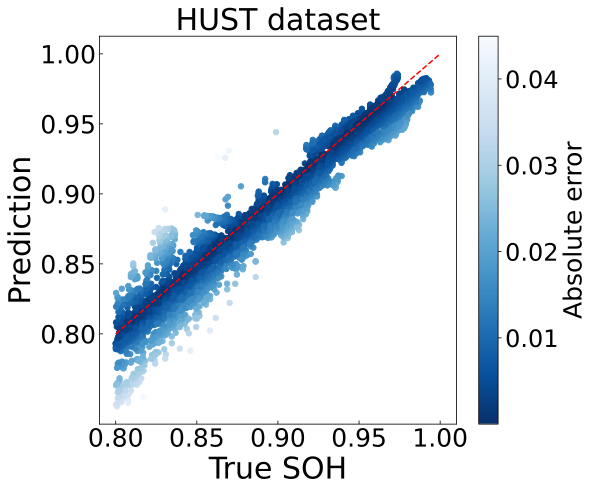

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# 示例数据
true_soh=np.concatenate((test_results[0][0],test_results[1][0],test_results[2][0]),axis=0)
# true_soh = test_results[1][0]
prediction=np.concatenate((test_results[0][1].reshape(-1),test_results[1][1].reshape(-1),test_results[2][1].reshape(-1)),axis=0)
# prediction = test_results[1][1].reshape(-1)

print(true_soh)
print(prediction)
def filter_arrays(arr1, arr2, threshold=0.8):
    """
    删除第一个数组中小于阈值的部分，并根据第一个数组删除的索引，删除第二个数组的对应值。

    参数:
    arr1 (np.array): 第一个数组。
    arr2 (np.array): 第二个数组。
    threshold (float): 阈值，默认为0.8。

    返回:
    filtered_arr1 (np.array): 过滤后的第一个数组。
    filtered_arr2 (np.array): 过滤后的第二个数组。
    """
    # 检查两个数组长度是否相同
    if len(arr1) != len(arr2):
        raise ValueError("两个数组的长度必须相同！")

    # 找到第一个数组中大于等于阈值的索引
    valid_indices = arr1 >= threshold

    # 根据索引过滤两个数组
    filtered_arr1 = arr1[valid_indices]
    filtered_arr2 = arr2[valid_indices]

    return filtered_arr1, filtered_arr2
true_soh,prediction=filter_arrays(true_soh,prediction)
# print(true_soh)
# print(prediction.reshape(-1))
distance = np.abs(true_soh - prediction) / np.sqrt(2)
# print(distance)
# 创建散点图
plt.figure(figsize=(8, 7))
scatter = plt.scatter(true_soh, prediction, c=distance, cmap='Blues_r', alpha=1,s=30)

# 添加中间红线
plt.plot([0.80, 1.00], [0.80, 1.00], color='red', linestyle='--')
plt.xticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
plt.yticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute error',fontsize=25)
cbar.ax.tick_params(labelsize=24)
# 设置最大刻度数为5
cbar.locator = MaxNLocator(nbins=5)
# 实际显示刻度数 = nbins + 1
cbar.update_ticks()
# 将刻度线画在坐标轴内部
plt.tick_params(axis='both', direction='in')

# 添加标签和标题
plt.xlabel('True SOH',fontsize=30)
plt.ylabel('Prediction',fontsize=30)
plt.title('HUST dataset',fontsize=30)
# plt.legend()

# 显示图表
plt.show()

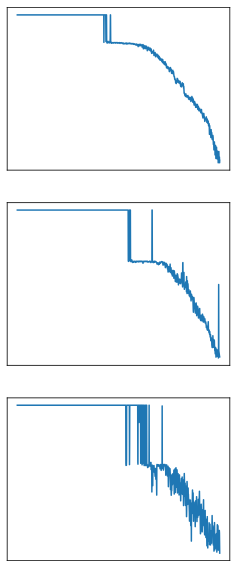

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(4, 10))
for i in range(3):
    # axes[i].plot(test_results[i][0][20:])
    # axes[i].plot(test_results[i][1][20:])
    axes[i].plot(lists[i][5])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].tick_params(axis='both', which='both', length=0)

In [11]:
for i in range(3):
    real,pred=test_results[i][0],test_results[i][1]
    rmse=evaluation(real,pred)
    print(rmse)

0.039437622059843754
0.018947346972750842
0.01918077180364281


In [10]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.003,epochs=100, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# test_results_mlp=train_mlp(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0012, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0012, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0030, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0014, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0012, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0012, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

KeyboardInterrupt: 

In [11]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
tests_mlp=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_mlp(seed=i,device=device)
    tests_mlp.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0159, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0195, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0030, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0031, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0018, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [13]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.0367699238932093, 0.028926955033233767, 0.01588687485639559, 0.03614118110533777, 0.02300124869466047, 0.023558092629573372, 0.03790930788640004, 0.02427400856456028, 0.027634764603757727, 0.03985764720205896, 0.0265197668865029, 0.03157578589058022, 0.035163860419720167, 0.021578320960318528, 0.018368172888506524]
MAE: [0.02808494262645976, 0.02669603556709663, 0.01239627433331871, 0.0262379143137274, 0.016341572228639537, 0.018256336110867164, 0.026676970843116064, 0.015318915512970011, 0.022330729174447752, 0.027727736190569095, 0.015522659904980704, 0.026924128542628576, 0.02600754417429007, 0.016959931715218205, 0.014447736501990454]
MAPE: [0.032224802874258655, 0.029551761031398723, 0.014757795064886128, 0.030885900755022153, 0.019297438632837515, 0.021812430817745268, 0.03169163186790156, 0.018412064719346484, 0.02678149376944656, 0.03304361189561683, 0.018908887838403596, 0.03215236728838578, 0.030411625462444098, 0.019650330936948072, 0.01713204688179693]
R2: [0.72390

In [13]:
# for i in range(3):
#     real,pred=test_results_mlp[i][0],test_results_mlp[i][1]
#     rmse=evaluation(real[:800],pred[:800])
#     print(rmse)

0.027297747838925187
0.020181227543381607
0.006852038259675917


In [14]:
class ConvNet(nn.Module):
    def __init__(self, n_input=11):
        super(ConvNet, self).__init__()
        # 输入重塑为 (batch, 1, n_input)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (n_input // 2), 64)  # 根据池化后的维度调整
        self.fc2 = nn.Sequential(nn.Linear(64 , 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 1),)
    
    def forward(self, x):
        # 输入 x 的形状: (batch, n_input)
        x = x.unsqueeze(1)  # 重塑为 (batch, 1, n_input)
        x = self.conv1(x)   # 卷积后形状: (batch, 32, n_input)
        x = self.relu(x)
        x = self.pool(x)    # 池化后形状: (batch, 32, n_input // 2)
        x = x.view(x.size(0), -1)  # 展平为 (batch, 32 * (n_input // 2))
        x = self.fc1(x)     # 全连接层
        x = self.relu(x)
        x = self.fc2(x)     # 输出形状: (batch, 1)
        return x
def train_conv(lr=0.003,epochs=100, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<1e-4 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# test_results_conv=train_conv(seed=0,device=device)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0028, device='cuda:0') 



KeyboardInterrupt: 

In [15]:
tests_cnn=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_conv(seed=i,device=device)
    tests_cnn.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0028, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0017, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0191, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0026, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0029, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0319, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0096, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [16]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests)):
    for j in range(len(tests[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.03203426944919068, 0.02536748729032237, 0.017853123961348173, 0.02683905898461563, 0.014681477584537516, 0.019118187925368603, 0.0372727782736485, 0.03046850274132789, 0.016722749397152854, 0.032276474006462594, 0.026873908502729624, 0.02576133120156848, 0.03282274953928708, 0.02395709058272415, 0.022179925558165656]
MAE: [0.02544355142016655, 0.023362253842682253, 0.014968716764562238, 0.021016946335122435, 0.010864487342015115, 0.016502456525082202, 0.029540424013682946, 0.02720173602874365, 0.013823170950548608, 0.022474709349857055, 0.0152044704788856, 0.0197999989355573, 0.0228460298130766, 0.017363793284028935, 0.020181084658573687]
MAPE: [0.029149328269154257, 0.025918887121990655, 0.01732299631867041, 0.02442909935536618, 0.012718173201502064, 0.019272785342653885, 0.03384633344107335, 0.02994877606937807, 0.015857663260041756, 0.026759546307384037, 0.018707950630860743, 0.023708493613097646, 0.027069127606234984, 0.020576383573147786, 0.023816915768903442]
R2: [0.7904

In [24]:
# for i in range(3):
#     real,pred=test_results_conv[i][0],test_results_conv[i][1]
#     rmse=evaluation(real[:800],pred[:800])
#     print(rmse)

0.020467741494864116
0.013052939559799559
0.012493940438274292


In [17]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=11, hidden_size=60, num_layers=6, output_size=1):
        """
        LSTM网络初始化
        :param input_size: 输入特征的维度 (n)
        :param hidden_size: 隐藏层的维度
        :param num_layers: LSTM的层数
        :param output_size: 输出的维度 (1)
        """
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 定义全连接层，将LSTM的输出映射到输出维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, input_size)
        :return: 输出数据，形状为 (batch_size, output_size)
        """
        # 添加序列维度 (sequence_length=1)
        x = x.unsqueeze(1)  # 形状变为 (batch_size, 1, input_size)

        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))  # out的形状为 (batch_size, 1, hidden_size)

        # 只取最后一个时间步的输出
        out = out[:, -1, :]  # 形状为 (batch_size, hidden_size)

        # 全连接层映射到输出维度
        out = self.fc(out)  # 形状为 (batch_size, output_size)

        return out

def train_lstm(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = LSTMNetwork()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
tests_lstm=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_lstm(seed=i,device=device)
    tests_lstm.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0019, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0013, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0012, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0015, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0011, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [19]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
for i in range(len(tests_lstm)):
    for j in range(len(tests_lstm[0])):
        real,pred=tests_lstm[i][j][0],tests_lstm[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        rmse_all.append(rmse)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("MAE:",mae_all)
print("MAPE:",mape_all)
print("R2:",r2)

RMSE: [0.034085358150585054, 0.029449724324557103, 0.025333024191782266, 0.02761241422228578, 0.02429325947410934, 0.02750137900799724, 0.02464725467576707, 0.021418902606737684, 0.01518557357630771, 0.021798474382236397, 0.015014962698429805, 0.020120821137234193, 0.02757390006424331, 0.022771650359445648, 0.024659056593717806]
MAE: [0.024303065836733025, 0.019322173144406724, 0.021136012986786593, 0.022067368699898955, 0.022512108655540194, 0.0217856072031267, 0.018132005313542175, 0.01758306781547527, 0.012018898495396049, 0.01766248876420211, 0.011824314502401593, 0.017897229321666357, 0.022175338357319517, 0.020442462242739188, 0.02002948467557748]
MAPE: [0.028863109038881233, 0.023232465593130747, 0.02499824862839703, 0.025021239886964405, 0.02465359956561844, 0.025388524484014956, 0.02117330791886932, 0.020142901142239465, 0.014258670759142264, 0.02030512398166735, 0.013448925443154703, 0.020610855578550434, 0.025252839658441616, 0.02249261946331546, 0.02331532978457157]
R2: [0.